# Interleaved Model Script
.
.
.


In [43]:
import sys
sys.path.append('../')

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

import os
from PIL import Image
import requests
import copy
import torch
import numpy as np

In [44]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [47]:
pretrained = "lmms-lab/llava-next-interleave-qwen-7b"
model_name = "llava_qwen"
device = torch.device("cuda:0")
device_map = {"": device}
llava_model_args = {
    "multimodal": True,
}
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, **llava_model_args)

model.to(device)
model.eval()


Loaded LLaVA model: lmms-lab/llava-next-interleave-qwen-7b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Overwriting config with {'image_aspect_ratio': 'pad'}
Loading vision tower: google/siglip-so400m-patch14-384


Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Model Class: LlavaQwenForCausalLM


LlavaQwenForCausalLM(
  (model): LlavaQwenModel(
    (embed_tokens): Embedding(151646, 4096)
    (layers): ModuleList(
      (0-31): 32 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
    (vis

In [48]:
def files_count(path):
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    return num_files

In [49]:
def return_prediction(question):
    conv_template = "qwen_1_5"
    conv = copy.deepcopy(conv_templates[conv_template])
    conv.append_message(conv.roles[0], question)
    conv.append_message(conv.roles[1], None)
    prompt_question = conv.get_prompt()
    input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    image_sizes = [image.size for image in images]
    cont = model.generate(
        input_ids,
        images=image_tensors,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0,
        max_new_tokens=4096,
    )
    text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
    print(text_outputs[0])
    return(text_outputs[0])

In [50]:
path_to_directory = "/nfs/np/mnt/big/tigrann/AirVLN_Data/val_seen_448x448/3IKDQS3DRMYCD4YN3FXL7EVVUSTCIO"
count = files_count(path_to_directory)
images = []
actions = []
instruction = "lower yourself to street level turn right until facing the road then head straight. at the next corner turn 180 degrees and head straight on the road. at the second intersection turn right onto the bridge and head straight. at the end of the road turn right. at the next intersection turn right. at the mural of the dog on the right turn left 90 degrees and head straight across the water. once on the road again turn right and stop at the first red building on the left."
description = "You are navigating a flying drone based on visual input and instructions. Analyze the current and previous images to determine the correct action to take from the provided options. Use the instruction and the differences between the images to guide your choice."

for i in range(count):
    path = f"{path_to_directory}/{i}.png"
 #   path =  path_to_directory + "/" + str(i) + ".png"
    image_current = Image.open(path)
    images.append(image_current)
    if i + 1 >= 10:
        images_10 = images[-10:]
        image_tensors = process_images(images_10, image_processor, model.config)
        image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
        image_tokens = "{DEFAULT_IMAGE_TOKEN}" * 9
        
        question = f"""
        [Description] {description} [/Description]
        [INSTR] {instruction} [/INSTR]
        [ACTIONS] {actions} [/ACTIONS]
        [PreviousScenes] {image_tokens} [PreviousScenes]
        [CurrentScene] {DEFAULT_IMAGE_TOKEN} [/CurrentScene]
        
        [Choice]
        0) STOP
        1) MOVE_FORWARD
        2) TURN_LEFT
        3) TURN_RIGHT
        4) GO_UP
        5) GO_DOWN
        6) MOVE_LEFT
        7) MOVE_RIGHT
        [/Choice]
        """ 
        actions.append(return_prediction(question))
        
    else:
        images_initial = images[-(i + 1):]
        image_tensors = process_images(images_initial, image_processor, model.config)
        image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
        image_tokens = "{DEFAULT_IMAGE_TOKEN}" * i

        question = f"""
        [Description] {description} [/Description]
        [INSTR] {instruction} [/INSTR]
        [ACTIONS] {actions} [/ACTIONS]
        [PreviousScenes] {image_tokens} [PreviousScenes]
        [CurrentScene] {DEFAULT_IMAGE_TOKEN} [/CurrentScene]
        
        [Choice]
        0) STOP
        1) MOVE_FORWARD
        2) TURN_LEFT
        3) TURN_RIGHT
        4) GO_UP
        5) GO_DOWN
        6) MOVE_LEFT
        7) MOVE_RIGHT
        [/Choice]
        """
        actions.append(return_prediction(question))

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [51]:
print(actions)

['1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']


In [7]:

import os
from PIL import Image
import requests
import copy
import torch
import numpy as np

path_to_directory = "/nfs/np/mnt/big/tigrann/AirVLN_Data/aerialvln-s_val_seen_448x448/302OLP89E75X7MFPRR58QG7CJ7VAC1"


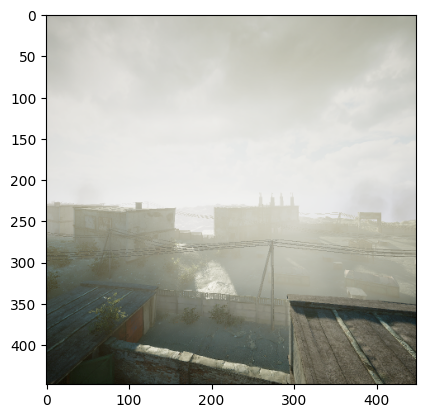

In [12]:
images = []


import matplotlib.pyplot as plt

path = f"{path_to_directory}/{30}.png"
image_current = Image.open(path)
images.append(image_current)

plt.imshow(image_current)

#Drafts

In [53]:
# path1 = "/nfs/ap/mnt/sxtn/AerialVLN/DATA/rgb_images/val_unseen/301KG0KXAKJZJRV104QUVPLUL5F2HR/0.npy"
# path2 = "/nfs/ap/mnt/sxtn/AerialVLN/DATA/rgb_images/val_unseen/301KG0KXAKJZJRV104QUVPLUL5F2HR/1.npy"

# url1 = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
# url2 = "https://raw.githubusercontent.com/haotian-liu/LLaVA/main/images/llava_logo.png"

# # image1 = np.load(path1)
# # image2 = np.load(path2)

# image1 = Image.open(requests.get(url1, stream=True).raw)
# image2 = Image.open(requests.get(url2, stream=True).raw)

# # image1 = Image.fromarray(image1.astype('uint8'))
# # image2 = Image.fromarray(image2.astype('uint8'))

# images = [image1, image2]
# image_tensors = process_images(images, image_processor, model.config)

# image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]

# instruction = "Take off, fly through the tower of cable bridge and down to the end of the road. Turn left, fly over the five-floor building with a yellow shop sign and down to the intersection on the left. Head to the park and turn right, fly along the edge of the park. March forward, at the intersection turn right, and finally land in front of the building with a red billboard on its rooftop"
# description = "You are navigating a flying drone based on visual input and instructions. Analyze the current and previous images to determine the correct action to take from the provided options. Use the instruction and the differences between the images to guide your choice."
# conv_template = "qwen_1_5"

# question = f"""
# [Description] {description} [/Description]
# [INSTR] {instruction} [/INSTR]
# [ACTIONS] {DEFAULT_IMAGE_TOKEN} [/ACTIONS]
# [CurrentScene] {DEFAULT_IMAGE_TOKEN} [/CurrentScene]

# [Choice]
# 0) STOP
# 1) MOVE_FORWARD
# 2) TURN_LEFT
# 3) TURN_RIGHT
# 4) GO_UP
# 5) GO_DOWN
# 6) MOVE_LEFT
# 7) MOVE_RIGHT
# [/Choice]
# """

In [54]:
# conv = copy.deepcopy(conv_templates[conv_template])
# conv.append_message(conv.roles[0], question)
# conv.append_message(conv.roles[1], None)
# prompt_question = conv.get_prompt()

In [55]:
# input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
# image_sizes = [image.size for image in images]

In [56]:
# cont = model.generate(
#     input_ids,
#     images=image_tensors,
#     image_sizes=image_sizes,
#     do_sample=False,
#     temperature=0,
#     max_new_tokens=4096,
# )
# text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
# print(text_outputs[0])